In [2]:
from collections import defaultdict

import pandas as pd
import numpy as np
import mne
import matplotlib.pyplot as plt

# from importlib import reload
# import feature_extraction
# reload(feature_extraction)
from plotting import (
    plot_series,
    plot_eeg_topomap_one_block,
    plot_eeg_topomap_all_blocks,
    plot_k_chaneels_by_r_value,
    plot_eeg_pearson_correlation_table,
    get_eeg_pearson_correlation_series_all_blocks,
    plot_time_series_by_epoch,
    plot_pearson_correlation_table_by_channel,
)
from biomarkers import (
    EEG,
    EMG,
    BP,
    EOG,
    Behavior,
    TREV,
    GSR,
    ALL_MARKERS,
    EEG_CHANEL_NAMES,
    EEG_NUM_CHANNELS,
)
from feature_extraction import (
    Feature,
    EEG_BANDS,
    FEATURE_TO_FUNC,
)
from data_utils import (
    load_data_from_dir,
    get_all_behaviors_labels,
    get_all_features_by_marker,
)
from calculate_correlation import (
    STAT_FEATURES,
    get_all_behaviors_feature_to_pc_by_markers,
    get_all_trials_average_rp_values,
)

# Train machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import (
    GroupKFold,
    GridSearchCV,
    cross_val_score,
    cross_validate,
)

In [3]:
ALL_DIRS = ["../2000_CleanData", "../2001_CleanData", "../1004_CleanData"]

dir_to_data = {}
for dir_name in ALL_DIRS:
    all_data = load_data_from_dir(dir_name)
    dir_to_data[dir_name] = all_data

Complete loading 10 markers
Loaded audio_hvla block
Complete loading 10 markers
Loaded breath_nvha block
Complete loading 10 markers
Loaded breath_hvha block
Complete loading 10 markers
Loaded audio_nvla block
Complete loading 10 markers
Loaded breath_hvla block
Complete loading 10 markers
Loaded audio_nvha block
Complete loading 10 markers
Loaded mind wandering block
Complete loading 10 markers
Loaded meditation block
Complete loading 10 markers
Loaded audio_hvha block
Complete loading 10 markers
Loaded breath_nvla block
Complete loading 10 markers
Loaded mind wandering block
Complete loading 10 markers
Loaded audio_hvla block
Complete loading 10 markers
Loaded breath_hvla block
Complete loading 10 markers
Loaded breath_nvla block
Complete loading 10 markers
Loaded audio_nvla block
Complete loading 10 markers
Loaded breath_nvha block
Complete loading 10 markers
Loaded audio_nvha block
Complete loading 10 markers
Loaded audio_hvha block
Complete loading 10 markers
Loaded meditation blo

In [7]:
num_channels = 2
num_blocks = 0

dir_name_to_features = {}
dir_name_to_labels = {}
features = STAT_FEATURES
marker = BP.__name__
channel_num = 1
for dir_name, all_data in dir_to_data.items():
    # ctf = get_all_behaviors_feature_to_pc_by_markers(
    #     all_data, marker, features, num_channels, num_blocks
    # )
    feature_to_value = get_all_features_by_marker(
        all_data, marker, features, channel_num
    )
            
    dir_name_to_features[dir_name] = feature_to_value
    dir_name_to_labels[dir_name] = get_all_behaviors_labels(all_data)

# avg_condition_to_features = get_all_trials_average_rp_values(dir_name_to_cf, features)

All labels shape: (130,)
All labels shape: (130,)
All labels shape: (130,)
All labels shape: (130,)
All labels shape: (130,)
All labels shape: (130,)
All labels shape: (130,)
All labels shape: (130,)
All labels shape: (130,)


In [8]:
features_to_trials = defaultdict()
for dir_name, fv in dir_name_to_features.items():
    for f, v in fv.items():
        if f not in features_to_trials:
            features_to_trials[f] = defaultdict()
        if dir_name not in features_to_trials[f]:
            features_to_trials[f][dir_name] = defaultdict()
        
        features_to_trials[f][dir_name] = v

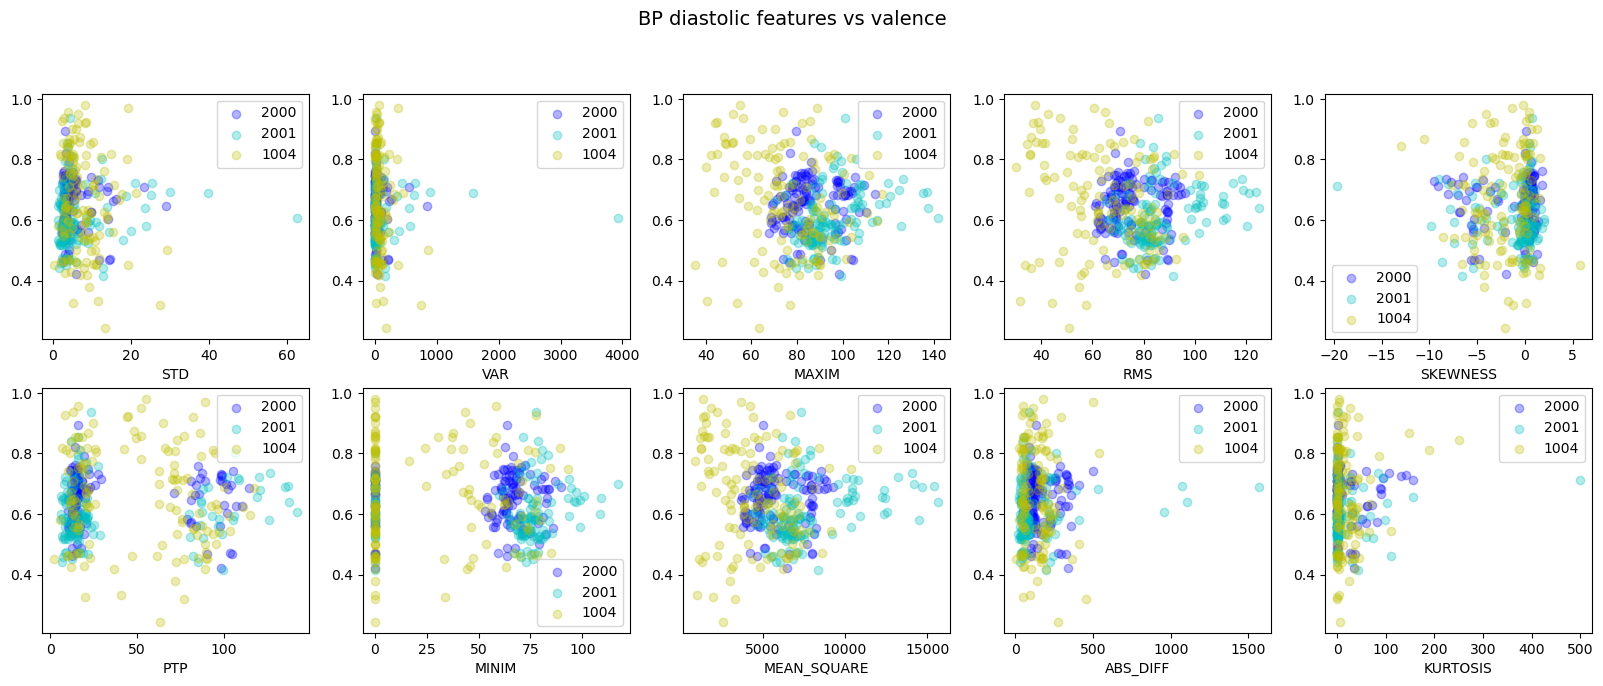

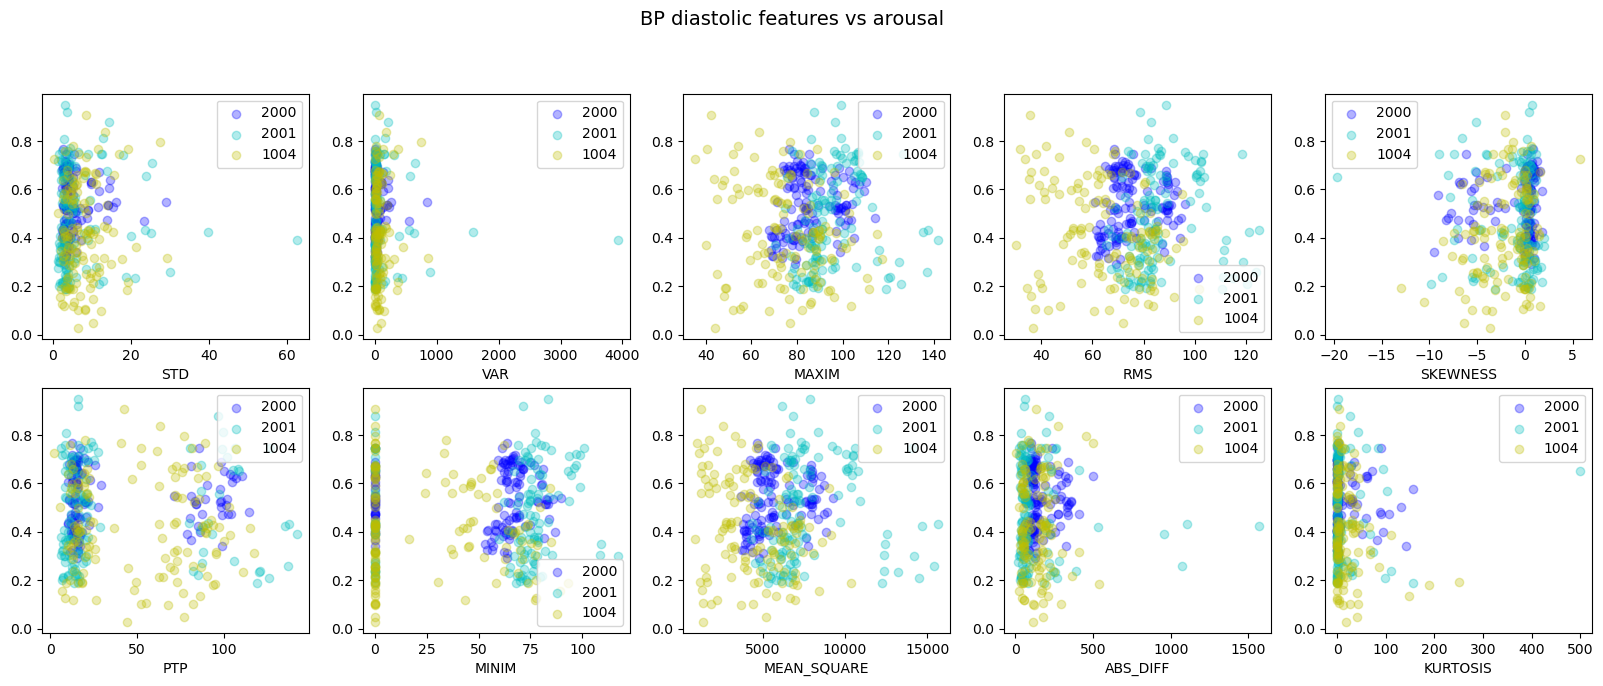

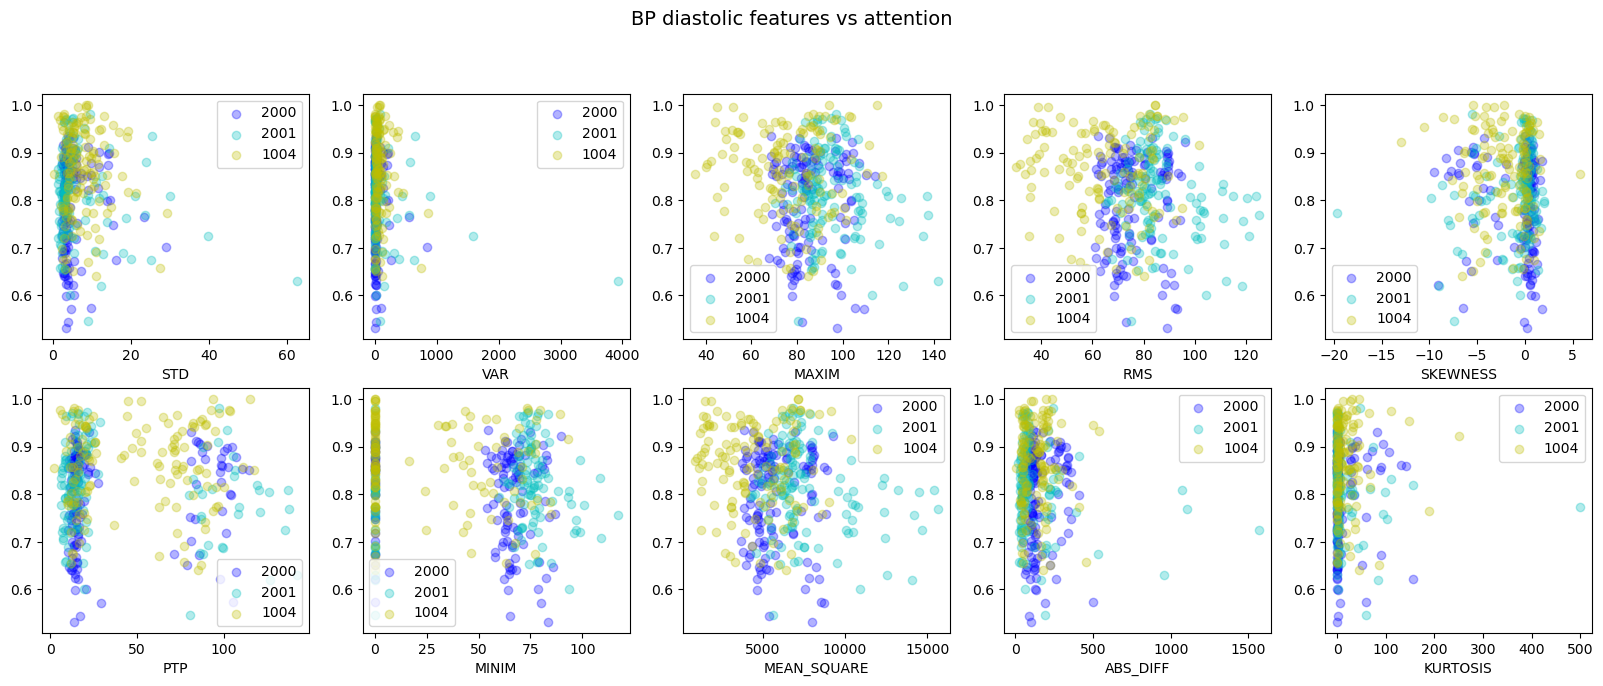

In [9]:
import matplotlib as mpl

colors = ['b', 'c', 'y', 'm', 'r']
for b in ['valence', 'arousal', 'attention']:
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 7))
    fig.suptitle(
        f"{marker} diastolic features vs {b}", fontsize=14, y=1
    )
    
    fidx = 0
    r, c = 0, 0    
    for f, trials in features_to_trials.items():
        cidx = 0
        r = int(fidx%2)
        c = int(fidx/2)
        for trial, val in trials.items():
            trial_name = trial.strip('../_CleanData')                
            labels = dir_name_to_labels[trial][b]
            axes[r][c].scatter(val, labels, c=colors[cidx], label=trial_name, alpha=0.3) # norm=mpl.colors.Normalize(vmin=0, vmax=2)
            axes[r][c].set_xlabel(f.name, fontsize=10)
            cidx+=1

        axes[r][c].legend()
        fidx+=1

    plt.show()

    

In [ ]:
all_data = dir_to_data["../2000_CleanData"]
channel_names = all_data["audio_hvla"].get_chanlocs(marker)

""" plot the time series given the marker and block
"""
# plot_time_series_by_epoch(all_data['audio_hvla'], 'EMG', 'audio_hvla', 0)


""" plot the single channel correlation table
"""
# channel = 1
# for condition, feature_to_pc in avg_condition_to_features.items():
#     label = f"{channel_names[channel]} {condition}"
#     plot_pearson_correlation_table_by_channel(
#         label, feature_to_pc, ["R-Value", "P-Value"], features, channel, True
#     )

""" plot the top channel correlation table given r values
"""
# for condition, feature_to_pc in avg_condition_to_features.items():
#     plot_k_chaneels_by_r_value(feature_to_pc, channel_names, features, condition, True, 2)
#     plot_k_chaneels_by_r_value(feature_to_pc, channel_names, features, condition, False, 2)


""" plot the top channel correlation table with different blocks
"""
# all_block_names = list(all_data.keys())
# all_block_names.sort()
# for condition, feature_to_pc in avg_condition_to_features.items():
#     plot_eeg_pearson_correlation_table(condition, feature_to_pc, all_block_names, 1)

""" plot the series for the top k channels
"""
# define number of rows and columns for subplots
# nrow = 3
# ncol = 2
# for condition, feature_to_pc in avg_condition_to_features.items():
#     print(f"{condition}")
#     ser_list = get_eeg_pearson_correlation_series_all_blocks(feature_to_pc, channel_names, k=20)
#     plot_series(nrow, ncol, ser_list)

""" plot the topography for eeg
"""
# for condition, feature_to_pc in avg_condition_to_features.items():
#     plot_eeg_topomap_all_blocks(condition, feature_to_pc)
#     for f in list(EEG_BANDS.keys()):
#         plot_eeg_topomap_one_block(condition, f, feature_to_pc, all_block_names)

In [ ]:
groups_list = [[i] for i, j in enumerate(valence_label)]
group_array = np.hstack(groups_list)

print(group_array)
print(all_features.shape, valence_label.shape, group_array.shape)

In [ ]:
def normalize_label(all_labels, low, high):
    y_transformed = []
    c0, c1, c2 = 0, 0, 0
    for label in all_labels:
        if label < low:
            y_transformed.append(0)
            c0 += 1
        elif label >= low and label < high:
            y_transformed.append(1)
            c1 += 1
        else:
            y_transformed.append(2)
            c2 += 1

    print(f"0 label: {c0}, 1 label: {c1}, 2 label {c2}")
    return y_transformed


def binary_label(all_labels, threshold=0.5):
    y_transformed = []
    c0, c1 = 0, 0
    for label in all_labels:
        if label < threshold:
            y_transformed.append(0)
            c0 += 1
        else:
            y_transformed.append(1)
            c1 += 1

    print(f"0 label: {c0}, 1 label: {c1}")
    return y_transformed


def get_tranformed_labels():
    name_to_transformed = dict()
    name_to_transformed["valence"] = binary_label(valence_label)  # 0.6, 0.8
    name_to_transformed["arousal"] = binary_label(arousal_label)  # 0.4, 0.7
    name_to_transformed["attention"] = binary_label(attention_label, 0.85)  # 0.82, 0.92
    return name_to_transformed


# convert y values to categorical values
name_to_transformed = get_tranformed_labels()

In [ ]:
label_name = "attention"
y_transformed = name_to_transformed[label_name]
clf = LogisticRegression(max_iter=200)
gkf = GroupKFold(n_splits=5)
param_grid = {"classifier__C": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]}
pipe = Pipeline([("scaler", StandardScaler()), ("classifier", clf)])
gscv = GridSearchCV(pipe, param_grid, cv=gkf, n_jobs=16)
gscv.fit(all_features, y_transformed, groups=group_array)

In [ ]:
best_model = gscv.best_estimator_
print(f"best model: {best_model}")
print(gscv.best_score_)

In [ ]:
# BP feature shape (13, 11)
# ECG feature shape (13, 11) 22
# EEG feature shape (13, 1408) 1430
# EGG feature shape (13, 11) 1441
# EMG feature shape (13, 22) 1463
# EOG feature shape (13, 22) 1485
# GSR feature shape (13, 11) 1496
# Resp feature shape (13, 11) 1507
# TREV feature shape (13, 11) 1518
# features = (mean(data),std(data),ptp(data),var(data),minim(data),maxim(data),
#                           mean_square(data),rms(data),abs_diffs_signal(data),
#                           skewness(data),kurtosis(data))
# EEG spetral features shape (13, 768) 2286-768=

STATS_NAME = [
    "mean",
    "std",
    "ptp",
    "var",
    "minim",
    "maxim",
    "mean_square",
    "rms",
    "abs_diffs_signal",
    "skewness",
    "kurtosis",
]
EEG_BANDS = ["Delta", "Theta", "Alpha", "Beta1", "Beta2", "Gamma"]


def get_stats_name(i) -> str:
    pos = i % 11
    return STATS_NAME[pos]


def get_feature_names(features):
    index = []
    for i, j in enumerate(features):
        stat_name = get_stats_name(i)
        if i < 11:
            name = "BP"
        elif i < 22:
            name = "ECG"
        elif i < 1430:
            channel = int((i - 22) / 11) + 1
            name = f"EEG {channel}"
        elif i < 1441:
            name = "EGG"
        elif i < 1463:
            channel = int((i - 1441) / 11) + 1
            name = f"EMG {channel}"
        elif i < 1485:
            channel = int((i - 1463) / 11) + 1
            name = f"EOG {channel}"
        elif i < 1496:
            name = "GSR"
        elif i < 1507:
            name = "Resp"
        elif i < 1518:
            name = "TREV"
        else:
            channel = int((i - 1518) / 6) + 1
            name = f"EEG {channel}"
            stat_name = EEG_BANDS[(i - 1518) % 6]

        index.append(f"{name} {stat_name}")
    return index

In [ ]:
# assume bigger coefficents has more contribution to the model
# but have to be sure that the features has THE SAME SCALE otherwise this assumption is not correct.
importance = best_model["classifier"].coef_[0]

feat_importances = pd.Series(importance, index=get_feature_names(importance))
feat_importances.nlargest(10).plot(
    kind="barh", title=f"{label_name} Feature Importance"
)

In [ ]:
# using Randoom forest (not suitable as the data is too small and the model will overfit easily)
# from sklearn.ensemble import RandomForestClassifier
# import matplotlib

# clf = RandomForestClassifier()
# clf = clf.fit(all_features,y_transformed)
# clf.feature_importances_
# feat_importances = pd.Series(clf.feature_importances_, index=get_feature_names(clf.feature_importances_))
# feat_importances.nlargest(20).plot(kind='barh',title = 'Feature Importance')